## Homology groups OGOB study
Use this groups to create protein families than can be alined and tested for positive selection later.

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Alphabet import IUPAC

In [2]:
pillars = pd.read_csv("fungi.poff.tsv","\t")

In [3]:
pillars.shape

(20243, 24)

In [4]:
pillars=pillars.replace("*",np.nan)

In [5]:
pillars = pillars.iloc[:,3:]

In [6]:
pillars["count"] = pillars.count(1)

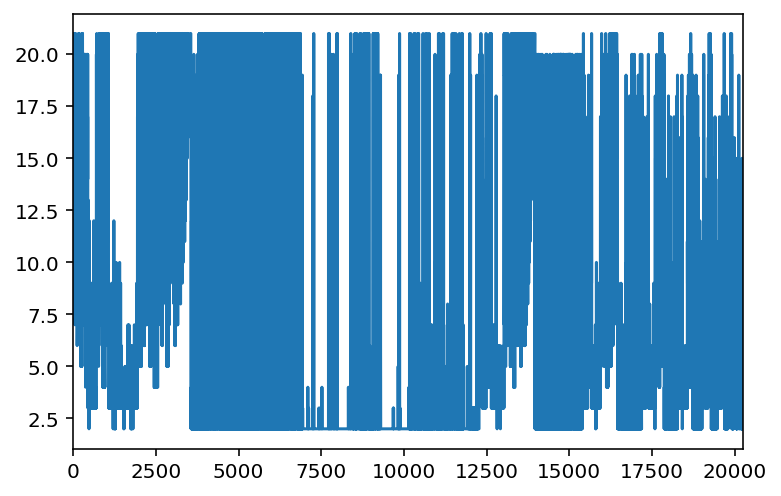

In [7]:
pillars["count"].plot()

In [8]:
pillars[pillars["count"]>4].shape

(6766, 22)

In [9]:
aa_all = SeqIO.index("AA.faa", "fasta", IUPAC.protein)
na_all = SeqIO.index("NT.fna", "fasta", IUPAC.ambiguous_dna)

In [10]:
pillars[pillars["count"]>4].loc[10][0:20]

Cryptococcus_gattii.faa               KIR58755.1
Cryptococcus_neoformans.faa       XP_012047457.1
Fomitiporia_mediterranea.faa      XP_007262728.1
Malassezia_globosa.faa            XP_001730234.1
Malassezia_restricta.faa          XP_027483169.1
Malassezia_sympodialis.faa        XP_018738865.1
Melampsora_larici-populina.faa    XP_007412705.1
Mixia_osmundae.faa                           NaN
Moniliophthora_roreri.faa             KTB30753.1
Paxillus_involutus.faa                KIJ08088.1
Piloderma_croceum.faa                 KIM85000.1
Puccinia_striiformis.faa              POW13151.1
Puccinia_triticina.faa                OAV97601.1
Rhizoctonia_solani.faa                       NaN
Rhodotorula_toruloides.faa        XP_016277086.1
Serendipita_indica.faa                CCA71897.1
Sporisorium_reilianum.faa             SJX64283.1
Trichosporon_asahii.faa           XP_014181756.1
Ustilago_bromivora.faa                SAM84692.1
Ustilago_hordei.faa                   CCF48870.1
Name: 10, dtype: obj

In [11]:
pillars["family"] = pillars.index

In [12]:
melted = pillars.melt(["family", "count"])

In [13]:
melted[melted["count"]>4].dropna()[["family","value"]].to_csv("fam.txt", "\t", index=False, header=False) 

In [14]:
nonamel = melted.dropna()

In [15]:
nonamel

,family,count,variable,value
0,0,14,Cryptococcus_gattii.faa,KIR58276.1
1,1,18,Cryptococcus_gattii.faa,KIR67911.1
2,2,17,Cryptococcus_gattii.faa,KIR68592.1
4,4,15,Cryptococcus_gattii.faa,KIR59908.1
5,5,20,Cryptococcus_gattii.faa,KIR57646.1
...,...,...,...,...
425072,20212,5,Ustilago_maydis.faa,XP_011386124.1
425073,20213,6,Ustilago_maydis.faa,XP_011387802.1
425078,20218,15,Ustilago_maydis.faa,XP_011387919.1
425079,20219,12,Ustilago_maydis.faa,XP_011386703.1


Plot number of families with duplicated genes

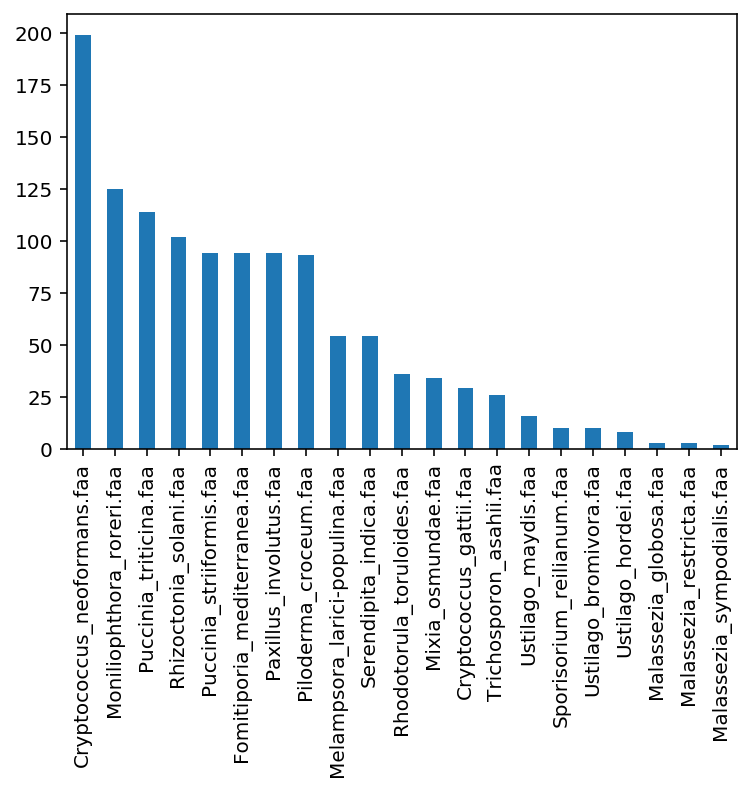

In [16]:
df=nonamel[nonamel["value"].str.contains(",")]
pd.value_counts(df['variable']).plot.bar()

Assign a protein family based on index number, store each row in a separate file 

In [17]:
for i in pillars[pillars["count"]>4].index:
    pillars[pillars["count"]>4].loc[i].to_csv("family/family" + str(i) + ".csv")

/Users/danielgomezperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


# Modify fam.txt to put duplications in the same family 

In [18]:
fam = pd.read_csv("fam.txt", "\t", header=None)

In [19]:
fam

,0,1
0,0,KIR58276.1
1,1,KIR67911.1
2,2,KIR68592.1
3,4,KIR59908.1
4,5,KIR57646.1
...,...,...
91545,20212,XP_011386124.1
91546,20213,XP_011387802.1
91547,20218,XP_011387919.1
91548,20219,XP_011386703.1


separate the second column by the comma.

In [20]:
fam_separated = fam[1].str.split(",",expand=True)

merge the separated dataframe with the regular one so that I get the family names

In [21]:
fam[1]= np.nan

In [22]:
merged =fam.merge(fam_separated, left_index=True,right_index=True).melt("0_x")

replace none in dataframe

In [23]:
merged.replace(to_replace=[None], value=np.nan, inplace=True)

In [24]:
merged["value"].dropna().str.contains(",").value_counts()

False    92388
Name: value, dtype: int64

In [25]:
merged[["0_x","value"]].dropna().to_csv("fam_dup.txt", "\t", index=False, header=False) 

# Make files for the nucleotide sequences

In [26]:
from Bio import SeqIO
from Bio import codonalign
from Bio import AlignIO
from Bio.Alphabet import generic_dna
from Bio.Alphabet import generic_protein

/Users/danielgomezperez/miniconda3/lib/python3.7/site-packages/Bio/codonalign/__init__.py:27: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [27]:
node_file = "fam_dup.txt"
na_file = "NT.fna"

In [28]:
famDict = {}
with open(node_file) as f:
        for line in f:
            row = line.split()
            if row[0] not in famDict:
                famDict[row[0]] = [row[1]]
            else:
                famDict[row[0]].append(row[1])

In [29]:
naseqDict = SeqIO.to_dict(SeqIO.parse(na_file, "fasta"))

In [30]:
for i in famDict.keys():
    file = "families/family_" + i + ".fna"
    with open(file, "w") as out:
        for j in famDict[i]:
            out.write('>' + j + '\n')
            out.write(str(naseqDict[j].seq) + '\n')

# Make files for the amino acid sequences

In [31]:
from Bio import SeqIO
from Bio import codonalign
from Bio import AlignIO
from Bio.Alphabet import generic_dna
from Bio.Alphabet import generic_protein

In [32]:
node_file = "fam_dup.txt"
aa_file = "AA.faa"

In [33]:
famDict = {}
with open(node_file) as f:
        for line in f:
            row = line.split()
            if row[0] not in famDict:
                famDict[row[0]] = [row[1]]
            else:
                famDict[row[0]].append(row[1])

In [34]:
aaseqDict = SeqIO.to_dict(SeqIO.parse(aa_file, "fasta"))

In [35]:
for i in famDict.keys():
    file = "families/family_" + i + ".faa"
    with open(file, "w") as out:
        for j in famDict[i]:
            out.write('>' + j + '\n')
            out.write(str(aaseqDict[j].seq) + '\n')